In [1]:
!pip3 install -U scikit-fuzzy

  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894074 sha256=eb2d56baf74c374422cead3c61b107c91a3385f2281003abdb4216211c16a3b3
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\2c\04\80\7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy


In [2]:
!pip3 install sympy

In [1]:
import random
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import sympy as sp
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from copy import deepcopy
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# the simulated price table
# VCPU 
# 0-10: 0.2€/st 1 month
# 11-30: 0.1
# 31-90: 0.05
# RAM 
# 0-20: 0.1€/per GB month
# 21-60: 0.05
# 61-180: 0.025
# VOLUME：
# 0-100：0.02€/per GB 1 month
# 101-300：0.01€/per GB 1 month
# 301-900：0.005€/per GB 1 month

In [27]:
def visualize_parameter(x_range,y_range,requirement,ylabel):
    if len(x_range)==1:
        print('only one round!')
        return 0
    plt.figure(figsize=[15, 5])
    x = x_range
    y = y_range
    x_diff = x_range[-1] - x_range[0]
    plt.xlim((x_range[0]-0.1*x_diff, x_range[-1]+0.1*x_diff))
    plt.ylim((10, 45))
    l1 = plt.plot(x, y, color='b',marker='o',linestyle='dashed',label='Provider proposal')
    #plt.axis([-5, x_range[-1]+5, requirement-10,  y_range[0]+10])
    plt.xlabel('round')
    plt.ylabel(ylabel)
    y_requirement = [requirement]*len(x_range)
    l2 = plt.plot(x, y_requirement, color='r',linestyle='dashed',label='Client requirement')
    plt.annotate('  Last Offer', xy=(x_range[-1],y_range[-1]), xytext=(x_range[-1],y_range[-1]-(y_range[0]-y_range[-1])*0.2),
            arrowprops=dict(facecolor='red',width=0.5, headwidth=7, shrink=0.005),
            )
    plt.legend(prop={'size': 15})
    plt.show()

In [4]:
def visualize_gain(parameter,offer_list,offer,requirement,total_fee,total_fee_old,avg,avg_old):  
    fig = plt.figure(figsize=[12, 8])
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    option = -1
    if parameter == 'vcpu':
        option = 0
    elif parameter == 'ram':
        option = 1
    elif parameter == 'storage':
        option = 2
    name_list = deepcopy(offer_list)
    name_list[-1] = 'final'
    amount_ratio = []
    fee_ratio = []
    total_fee_ax2 = []
    total_fee_ratio = []
    for i in offer_list:
        print(i)
        amount_ratio.append(offer[i]/requirement[option])
        fee_ratio.append((offer[i]*avg[i])/(requirement[option]*avg_old))
        total_fee_ratio.append(total_fee[i]/total_fee_old)
        total_fee_ax2.append(total_fee[i])
       
    x1 = list(range(len(name_list)))
    x2 = list(range(len(name_list)))
    x3 = list(range(len(name_list)))
    total_width, n = 1.1, 4
    width = total_width / n
    
    x0 = list(range(-1,len(name_list)+1))
    y_requirement = [1.0]*len(x0)
    ax1.plot(x0, y_requirement, color='r',linestyle='dashed',label='Ratio: Baseline = 1.0')
    
    for i in range(len(x1)):
        x1[i] = x1[i] - width
    ax1.bar(x1, amount_ratio, width=width, label='Ratio: Amount of '+parameter, fc='c')
    ax1.bar(x2, fee_ratio, width=width, label='Ratio: Fee of '+parameter, tick_label=name_list, fc='y')
    for i in range(len(x3)):
        x3[i] = x3[i] + width
    ax1.bar(x3, total_fee_ratio, width=width, label='Ratio: Total fee', fc='g')
    
    for a,b in zip(x1,amount_ratio):  
        ax1.text(a, b+0.02, '%.3f' % b, ha='center', va= 'bottom',fontsize=8) 
    for a,b in zip(x2,fee_ratio):  
        ax1.text(a, b+0.02, '%.3f' % b, ha='center', va= 'bottom',fontsize=8)     
    for a,b in zip(x3,total_fee_ratio):  
        ax1.text(a, b+0.02, '%.3f' % b, ha='center', va= 'bottom',fontsize=8) 
    
    
    ax2.plot(x2, total_fee_ax2, color='b',marker='o',linestyle='dashed',label='Total fee')
    ax2.set_ylim(0, 1.1*max(total_fee_ax2))
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Ratio')
    ax2.set_ylabel('Total fee')
    fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax2.transAxes)
    plt.title(label='Related ratios of '+parameter,fontsize=20)
    print('Saving fig...')
    plt.savefig('ratio_'+parameter+'.jpg')
    print('Complete!')
    plt.show()

In [5]:
# Class for provider
class provider_base:
    min_change = [1, 1, 10]
    # input the initial number of vcpu,ram,volume
    def __init__(self, n_vcpu0 = 0, n_ram0 = 0, n_volume0 = 0):
        self.n_vcpu0 = n_vcpu0
        self.n_ram0 = n_ram0
        self.n_volume0 = n_volume0
        
    # Functions for controlling the value range of issues
    def vcpu_range(self,n):
        n_initial = 0
        if 0 < n <= 10:
            n_initial = 10+n
        elif 11 <= n <= 30:
            n_initial = 30+n
        elif 31 <= n <= 90:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def ram_range(self,n):
        n_initial = 0
        if 0 < n <= 20:
            n_initial = 20+n
        elif 21 <= n <= 60:
            n_initial = 60+n
        elif 61 <= n <= 180:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def volume_range(self,n):
        n_initial = 0
        if 0 < n <= 100:
            n_initial = 100+n
        elif 101 <= n <= 300:
            n_initial = 300+n
        elif 301 <= n <= 900:
            n_initial = n
        else:
            print('Out of Range!')
            return -1
        return n_initial

    def initial_offer(self,client_requirement):
        n_vcpu0 = self.vcpu_range(client_requirement[0])
        n_ram0 = self.ram_range(client_requirement[1])
        n_volume0 = self.volume_range(client_requirement[2])
        return n_vcpu0,n_ram0,n_volume0
    
    def compute_ratio(self,client_requirement,client_priorities):
        # 10/20/200, 1.5/1.1/1.0
        # ratio = i/client_requirement[0]: 1/2/20
        # Original is 10*ratio
        # To keep the ratio means N*ratio
        # From 10/20/200 to 9/18/180.
        # 1 round for vcpu, 2 rounds for ram, 2 rounds for storage.
        # 5 rounds are needed
        # Probability is 1/5 for vcpu, 2/5 for ram, 2/5 for storage.
        # Modify the probability according to priority
        # 1/1.5 round for vcpu, 2/1.1 rounds for ram, 2/1 rounds for storage.
        # 1/1.5+2/1.1+2/1 rounds are needed
        ratio = [i/client_requirement[0] for i in client_requirement]
        times1round_vcpu = ratio[0]/provider_base.min_change[0]/client_priorities['vcpu']
        times1round_ram = ratio[1]/provider_base.min_change[1]/client_priorities['ram']
        times1round_volume = ratio[2]/provider_base.min_change[2]/client_priorities['volume']
        times1round = times1round_vcpu+times1round_ram+times1round_volume
        #print(times1round_vcpu,times1round_ram,times1round_volume,times1round)
        
        return times1round_vcpu,times1round_ram,times1round_volume,times1round
               
    def update_offer(self,times1round_vcpu,times1round_ram,times1round_volume,times1round,
                     n_vcpu0,n_ram0,n_volume0,
                     client_requirement,client_advice):
        if client_advice == 'random':
            # like random gradient decent
            rand_int = random.uniform(0, times1round)
            t1 = 0+times1round_vcpu
            t2 = t1+times1round_ram
            t3 = t2+times1round_volume

            if 0<=rand_int<=t1:
                if n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]
                elif n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
                elif n_volume0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]

            elif t1<rand_int<=t2:
                if n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
                elif n_volume0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]
                elif n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]

            elif t2<rand_int<=t3:
                if n_volume0 > client_requirement[2]:
                    n_volume0=n_volume0-provider_base.min_change[2]
                elif n_vcpu0 > client_requirement[0]:
                    n_vcpu0=n_vcpu0-provider_base.min_change[0]
                elif n_ram0 > client_requirement[1]:
                    n_ram0=n_ram0-provider_base.min_change[1]
        else:
            if client_advice == 'vcpu':
                n_vcpu0=n_vcpu0-provider_base.min_change[0]
                #print('reduce vcpu')
            elif client_advice == 'ram':
                n_ram0=n_ram0-provider_base.min_change[1]
                #print('reduce ram')
            elif client_advice == 'volume':
                n_volume0=n_volume0-provider_base.min_change[2]
                #print('reduce volume')
            else:
                print('Wrong!')
                return -1
            
        return n_vcpu0,n_ram0,n_volume0        

In [6]:
# Class for client
class client_base:
    def __init__(self, client_requirement=[0,0,0]):
        self.requirement = client_requirement
              
    def compute_fee(self, p1, p2, p3, t1, t2, n):
        fee = 0
        if 0 < n <= t1:
            fee = p1*n
        elif t1 < n <= t2:
            fee = p1*t1+p2*(n-t1)
        elif t2 < n :
            fee = p1*t1+p2*(t2-t1)+p3*(n-t2)
        else:
            print('Out of Range!')
            return -1
        return fee
    
    def compute_avg_price(self, fee, num):
        return fee/num
    
    def compute_total_fee(self, f1, f2, f3):
        return f1+f2+f3
    
    def scale2one_avg(self, obj, old, new):
        ratio = new/old
        # the avg price ratio
        # new/old: the cheaper, the better
        # ratio: close to 0 is better, close to 1 is worse
        if obj == 'avg':
            return ratio
        # the total fee ratio
        # new total fee is always larger than old total fee
        # ratio is larger than 1, the larger the worse
        # the reciproval is between o and 1. the closer to 0, the worse
        # the closer to 1, the better
        elif obj == 'total':
            return 1/ratio
    
    def related_fee(self, client_requirement = None):
        
        if client_requirement == None:
            client_requirement = self.requirement
            
        vcpu_fee_r = self.compute_fee(0.2,0.1,0.05,10,30,client_requirement[0])
        vcpu_avg_r = self.compute_avg_price(vcpu_fee_r,client_requirement[0])
        ram_fee_r = self.compute_fee(0.1,0.05,0.025,20,60,client_requirement[1])
        ram_avg_r = self.compute_avg_price(ram_fee_r,client_requirement[1])
        volume_fee_r = self.compute_fee(0.02,0.01,0.005,100,300,client_requirement[2])
        volume_avg_r = self.compute_avg_price(volume_fee_r,client_requirement[2])
        total_fee_r = vcpu_fee_r+ram_fee_r+volume_fee_r
        return vcpu_avg_r,ram_avg_r,volume_avg_r,total_fee_r
    
    def fuzzy_decision(self):
        # Fuzzy logic

        # New Antecedent/Consequent objects hold universe variables and membership functions
        avg_vcpu = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_vcpu')
        avg_ram = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_ram')
        avg_volume = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_volume')
        total_fee = ctrl.Antecedent(np.arange(0, 101, 1), 'total_fee')

        tendency = ctrl.Consequent(np.arange(0, 101, 1), 'tendency')

        # Auto-membership function population is possible with .automf(3, 5, or 7)
        # poor average good, automatically
        #names_avg = ['cheap','medium','expensive']
        #avg_vcpu.automf(names = names_avg)
        #avg_ram.automf(names = names_avg)
        #avg_volume.automf(names = names_avg)
        avg_vcpu['cheap'] = fuzz.gaussmf(avg_vcpu.universe, 0, 50.0/3)
        avg_vcpu['medium'] = fuzz.gaussmf(avg_vcpu.universe, 50, 50.0/3)
        avg_vcpu['expensive'] = fuzz.gaussmf(avg_vcpu.universe, 100, 50.0/3)

        avg_ram['cheap'] = fuzz.gaussmf(avg_ram.universe, 0, 50.0/3)
        avg_ram['medium'] = fuzz.gaussmf(avg_ram.universe, 50, 50.0/3)
        avg_ram['expensive'] = fuzz.gaussmf(avg_ram.universe, 100, 50.0/3)

        avg_volume['cheap'] = fuzz.gaussmf(avg_volume.universe, 0, 50.0/3)
        avg_volume['medium'] = fuzz.gaussmf(avg_volume.universe, 50, 50.0/3)
        avg_volume['expensive'] = fuzz.gaussmf(avg_volume.universe, 100, 50.0/3)

        #names_total = ['high','medium','low']
        #total_fee.automf(names = names_total)
        # x>2 original, weak accepted --> totalfee<0.5
        # 2>x>1.5, medium accepted --> 0.5<totalfee<0.8
        # 1.5>x, strong accepted --> totalfee>0.8
        total_fee['high'] = fuzz.gaussmf(total_fee.universe, 0, 38.8888888888889)
        total_fee['medium'] = fuzz.gaussmf(total_fee.universe, 65.0, (100-65.0)/3)
        total_fee['low'] = fuzz.gaussmf(total_fee.universe, 100, 15.5555555555555)
        # Custom membership functions can be built interactively with a familiar,
        # Pythonic API
        tendency['low'] = fuzz.gaussmf(tendency.universe, 0, 50.0/3)
        tendency['medium'] = fuzz.gaussmf(tendency.universe, 50, 50.0/3)
        tendency['high'] = fuzz.gaussmf(tendency.universe, 100, 50.0/3)
        
        # Rules
        # cheap:1,medium:2,expensive:3
        # sum: 3, 4, 5, 6, 7, 8, 9
        # tendency: 3, 4 high / 5, 6 ,7 medium / 8, 9 low
        # could be adjusted
        rule01 = ctrl.Rule(total_fee['high'], tendency['low'])
        rule02 = ctrl.Rule(total_fee['medium'], tendency['medium'])
        rule03 = ctrl.Rule(total_fee['low'], tendency['high'])
        
        rule11 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['cheap'], tendency['high'])#3
        rule12 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['medium'], tendency['high'])#4
        rule13 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#5
        rule14 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['cheap'], tendency['high'])#4
        rule15 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#5
        rule16 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['expensive'], tendency['medium'])#6
        rule17 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#5
        rule18 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['medium'], tendency['medium'])#6
        rule19 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['expensive'], tendency['medium'])#7
        
        rule21 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['cheap'], tendency['high'])#4
        rule22 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['medium'], tendency['medium'])#5
        rule23 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#6
        rule24 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['cheap'], tendency['medium'])#5
        rule25 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#6
        rule26 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['expensive'], tendency['medium'])#7
        rule27 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#6
        rule28 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['medium'], tendency['medium'])#7
        rule29 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['expensive'], tendency['low'])#8
        
        rule31 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['cheap'], tendency['medium'])#5
        rule32 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['medium'], tendency['medium'])#6
        rule33 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#7
        rule34 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['cheap'], tendency['medium'])#6
        rule35 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#7
        rule36 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['expensive'], tendency['low'])#8
        rule37 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#7
        rule38 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['medium'], tendency['low'])#8
        rule39 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['expensive'], tendency['low'])#9

        
        # Fuzzy decision simulation
        decision_ctrl = ctrl.ControlSystem([rule01, rule02, rule03, \
                                            rule11, rule12, rule13, rule14, rule15, rule16, rule17, rule18, rule19, \
                                            rule21, rule22, rule23, rule24, rule25, rule26, rule27, rule28, rule29, \
                                            rule31, rule32, rule33, rule34, rule35, rule36, rule37, rule38, rule39, \
                                           ])
        decision = ctrl.ControlSystemSimulation(decision_ctrl)
        
        return decision,tendency
    
    def advice(self, offer, client_requirement, priority, threshold):
        # we would like to keep the original ratio
        # if the offer ratio is the same as the requirement
        # the following ratio should be the same
        vcpu_ratio = offer[0]/client_requirement[0]
        ram_ratio = offer[1]/client_requirement[1]
        volume_ratio = offer[2]/client_requirement[2]
        ratio_dict ={'vcpu':vcpu_ratio, 'ram':ram_ratio, 'volume':volume_ratio}
        max_item = max(ratio_dict, key=ratio_dict.get)
        min_item = min(ratio_dict, key=ratio_dict.get)
        difference_ratio = ratio_dict[max_item]/ratio_dict[min_item]
        if priority == []:
            #print('situation 1')
            if difference_ratio > threshold:
                return max_item
            else:
                return 'random'
        else:
            #print('situation 2')
            if max_item == priority[0]:
                #print('max item: ',max_item,' priority: ',priority[0],' threshold: ',threshold[0])
                if difference_ratio > threshold[0]:
                    return max_item
                else:
                    return 'random'
            elif max_item == priority[1]:
                #print('max item: ',max_item,' priority: ',priority[1],' threshold: ',threshold[1])
                if difference_ratio > threshold[1]:
                    return max_item
                else:
                    return 'random'            
            elif max_item == priority[2]:
                #print('max item: ',max_item,' priority: ',priority[2],' threshold: ',threshold[2])
                if difference_ratio > threshold[2]:
                    return max_item
                else:
                    return 'random'
            else:
                print('Error!')
                return -1

# The simulated price table
## VCPU 
0-10: 0.2€/st 1 day  
11-30: 0.1  
31-90: 0.05  
## RAM 
0-20: 0.1€/per GB day  
21-60: 0.05  
61-180: 0.025  
## VOLUME：
0-100：0.02€/per GB 1 day  
101-300：0.01€/per GB 1 day  
301-900：0.005€/per GB 1 day  

In [7]:
# Negotiation

# order: CPU-st, RAM-GB, VOLUME-GB
# client_requirement = [15, 30, 225] 
def negotiation_client_advice(client_requirement,client_priorities):
#def negotiation_client_advice(client_requirement,client_priorities,train_list):
    
    # Client
    client = client_base(client_requirement)
    client_decision,tendency = client.fuzzy_decision()
    # different priority correspond to different threshold
    client_priority = []
    client_threshold = []
    for key,value in client_priorities.items():
        client_priority.append(key)
        client_threshold.append(value)
    #print(client_priority)
    #print(client_threshold)
    # Provider
    provider = provider_base()
    offer = provider.initial_offer(client_requirement)
    times1round_vcpu,times1round_ram,times1round_volume,times1round = provider.compute_ratio(client_requirement,client_priorities)
    #print('/vcpu rounds: ',times1round_vcpu,'/ram rounds: ',times1round_ram,'/volume rounds: ',times1round_volume,'/total rounds: ',times1round)
    # Original price, i.e. baseline
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old = client.related_fee()
    #print('*********************************************************************')
    #print('Client requirement: ', client_requirement)
    #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_old,ram_avg_old,volume_avg_old))
    #print('total_fee: %f'%total_fee_old)
    #print('*********************************************************************')
    # For plotting
    steps = [];vcpu = [];ram = [];volume = [];avg_vcpu = [];avg_ram = [];avg_volume = [];total_fee = []
    #print('Provider first offer: ',offer)
    max_rounds = 150
    i = 0;
    while True:
        # New fees
        vcpu_avg_new,ram_avg_new,volume_avg_new,total_fee_new = client.related_fee(offer)
        # Store offer and fee
        steps.append(i);vcpu.append(offer[0]);ram.append(offer[1]);volume.append(offer[2])
        avg_vcpu.append(vcpu_avg_new);avg_ram.append(ram_avg_new);avg_volume.append(volume_avg_new);total_fee.append(total_fee_new)
        # input of fuzzy system
        input_avg_vcpu = 100*client.scale2one_avg('avg', vcpu_avg_old, vcpu_avg_new)
        input_avg_ram = 100*client.scale2one_avg('avg', ram_avg_old, ram_avg_new)
        input_avg_volume = 100*client.scale2one_avg('avg', volume_avg_old, volume_avg_new)
        input_total_fee = 100*client.scale2one_avg('total', total_fee_old, total_fee_new)
        dict_of_data = {'avg_vcpu':input_avg_vcpu,'avg_ram':input_avg_ram,'avg_volume':input_avg_volume,'total_fee':input_total_fee}
        #dict_of_data = {'avg_vcpu':5,'avg_ram':5,'avg_volume':5,'total_fee':2}
        #print(dict_of_data)

        # Client makes decision
        client_decision.inputs(dict_of_data)
        # Crunch the numbers
        client_decision.compute()
        decision_score = client_decision.output['tendency']
        
        # This part is for training scores, if no need, please comment out them.
        #train_list_dict = {'request_vcpu':client_requirement[0], 'request_ram':client_requirement[1], 'request_volume':client_requirement[2],\
        #                   'offer_vcpu':offer[0], 'offer_ram':offer[1], 'offer_volume':offer[2],\
        #                   'offer_score':decision_score }
        #train_list.append(train_list_dict)
        
        # Part for printing
        #print('---------------------------------------------------------------')
        #print('offer %d: '%i , offer, ' its score: ',decision_score)
        #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
        #print('total_fee: %f'%total_fee_new)
        #print('---------------------------------------------------------------')

        # if accepet
        if decision_score >= 50:
            final_offer = offer
            print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
            print('This final offer is ',final_offer)
            print('Decision_score is ',decision_score)
            print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
            print('total_fee: %f'%total_fee_new)
            #tendency.view(sim=None)
            #tendency.view(sim=client_decision)
            #print(tendency)
            #print('-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-')
            break
        # if reject  
        else:
            if offer[0]>=client_requirement[0] and offer[1]>=client_requirement[1] and offer[2]>=client_requirement[2]:
                
                client_advice = client.advice(offer,client_requirement,client_priority,client_threshold)
                #print('client advice: ',client_advice)
                #print('           ')
                
                offer = provider.update_offer(times1round_vcpu,times1round_ram,times1round_volume,times1round,
                                              offer[0],offer[1],offer[2],
                                             client_requirement,client_advice)
                #print(offer)
            else:
                final_offer = offer
                #print('Round:',i,'break!')
                #print('Last offer (also the final offer): ' , final_offer, ' its score: ',decision_score)
                #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
                #print('total_fee: %f'%total_fee_new) 
                break
        i = i+1
        if i > max_rounds:
            final_offer = offer
            #print('Round %d'%i,' . Reach the MAX round!')
            #print('Last offer (also the final offer): ' , final_offer, ' its score: ',decision_score)
            #print('vcpu_avg_price: %f, ram_avg_price: %f, volume_avg_price: %f'%(vcpu_avg_new,ram_avg_new,volume_avg_new))
            #print('total_fee: %f'%total_fee_new)       
            break
        
    #print(i,' rounds')
    return steps,vcpu,ram,volume,vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,avg_vcpu,avg_ram,avg_volume,total_fee,final_offer


# Single test

In [8]:
random.seed(19260817)
vcpu = 11
ram = 85
volume = 230  
client_requirement = [vcpu, ram, volume]
client_priorities = {'vcpu':1.0,'ram':1.0,'volume':1.0}
time_start=time.time()
steps,vcpu,ram,volume,\
vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
avg_vcpu,avg_ram,avg_volume,total_fee,\
final_offer = negotiation_client_advice(client_requirement,client_priorities)
time_end=time.time()
print('time cost',time_end-time_start,'s')

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
This final offer is  (10, 21, 210)
Decision_score is  50.00360586349431
vcpu_avg_price: 0.200000, ram_avg_price: 0.097619, volume_avg_price: 0.014762
total_fee: 7.150000
time cost 0.3182206153869629 s


In [9]:
final_offer

(10, 21, 210)

In [10]:
len(steps)

59

# Generate offer data set
Thit part needs to modify the negotiation part.

## test

In [96]:
random.seed(19260817)
x_test = pd.read_csv('./data/offer_ML/x_test_200_v1.csv',index_col=0).reset_index(drop=True)

In [97]:
test_final_offer_list = []
for index,row in tqdm(x_test.iterrows(),total=x_test.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.00,'volume':1.00}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    test_final_offer_list.append(final_offer_dict)
y_test = pd.DataFrame(test_final_offer_list)
y_test.to_csv('./data/offer_ML/v4_y_test_200_v1_p1.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:59<00:00,  3.36it/s]


In [98]:
test_final_offer_list = []
for index,row in tqdm(x_test.iterrows(),total=x_test.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.1,'ram':1.00,'volume':1.00}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    test_final_offer_list.append(final_offer_dict)
y_test = pd.DataFrame(test_final_offer_list)
y_test.to_csv('./data/offer_ML/v4_y_test_200_v1_p11.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.42it/s]


In [99]:
test_final_offer_list = []
for index,row in tqdm(x_test.iterrows(),total=x_test.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.5,'ram':1.00,'volume':1.00}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    test_final_offer_list.append(final_offer_dict)
y_test = pd.DataFrame(test_final_offer_list)
y_test.to_csv('./data/offer_ML/v4_y_test_200_v1_p15.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]


In [100]:
test_final_offer_list = []
for index,row in tqdm(x_test.iterrows(),total=x_test.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':5,'ram':1.00,'volume':1.00}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    test_final_offer_list.append(final_offer_dict)
y_test = pd.DataFrame(test_final_offer_list)
y_test.to_csv('./data/offer_ML/v4_y_test_200_v1_p5.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]


## Train size = 10000

In [11]:
x_train_104 = pd.read_csv('./data/offer_ML/x_train_104_v1.csv',index_col=0).reset_index(drop=True)

In [12]:
train_final_offer_list = []
for index,row in tqdm(x_train_104.iterrows(),total=x_train_104.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.0,'volume':1.0}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_104 = pd.DataFrame(train_final_offer_list)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [54:06<00:00,  3.08it/s]


In [13]:
y_train_104.to_csv('./data/offer_ML/v4_y_train_104_v1.csv')

## size = 20000

In [8]:
x_train_204 = pd.read_csv('./data/offer_ML/x_train_204.csv',index_col=0).reset_index(drop=True)

In [9]:
train_final_offer_list = []
for index,row in tqdm(x_train_204.iterrows(),total=x_train_204.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.05,'volume':1.0}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_204 = pd.DataFrame(train_final_offer_list)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [1:12:39<00:00,  4.59it/s]


In [10]:
y_train_204.to_csv('./data/offer_ML/v4_y_train_204.csv')

## size = 40000

In [8]:
x_train_404 = pd.read_csv('./data/offer_ML/x_train_404.csv',index_col=0).reset_index(drop=True)
part1 = x_train_404[0:10000]
part2 = x_train_404[10000:20000]
part3 = x_train_404[20000:30000]
part4 = x_train_404[30000:40000]

In [9]:
train_final_offer_list = []
for index,row in tqdm(part1.iterrows(),total=part1.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.05,'volume':1.0}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_404_1 = pd.DataFrame(train_final_offer_list)
#y_train_404_1.to_csv('./data/offer_ML/v4_y_train_404_1.csv')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [44:54<00:00,  3.71it/s]


In [10]:
train_final_offer_list = []
for index,row in tqdm(part2.iterrows(),total=part2.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.05,'volume':1.0}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_404_2 = pd.DataFrame(train_final_offer_list)
#y_train_404_2.to_csv('./data/offer_ML/v4_y_train_404_2.csv')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [47:00<00:00,  3.55it/s]


In [11]:
train_final_offer_list = []
for index,row in tqdm(part3.iterrows(),total=part3.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.05,'volume':1.0}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_404_3 = pd.DataFrame(train_final_offer_list)
#y_train_404_3.to_csv('./data/offer_ML/v4_y_train_404_3.csv')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [39:58<00:00,  4.17it/s]


In [12]:
train_final_offer_list = []
for index,row in tqdm(part4.iterrows(),total=part4.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.05,'volume':1.0}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_404_4 = pd.DataFrame(train_final_offer_list)
y_train_404_4.to_csv('./data/y_train_404_4.csv')

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [43:54<00:00,  3.80it/s]


In [15]:
y_train_404_list = [y_train_404_1,y_train_404_2,y_train_404_3,y_train_404_4]
y_train_404 = pd.concat(y_train_404_list)

In [24]:
y_train_404.to_csv('./data/offer_ML/v4_y_train_404.csv')

# Generate score data set

# test

In [43]:
x_test = pd.read_csv('./data/offer_ML/x_test_200.csv',index_col=0).reset_index(drop=True)
x_test_20 = x_test[0:20]
x_test_20.to_csv('./data/score_ML/x_test_20.csv')

In [36]:
test_final_offer_list = []
test_list = []
for index,row in tqdm(x_test_20.iterrows(),total=x_test_20.shape[0]):
    
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.05,'volume':1.0}
    
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities,test_list)
    
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    test_final_offer_list.append(final_offer_dict)
    
y_test_20 = pd.DataFrame(test_final_offer_list)
score_test_20 = pd.DataFrame(test_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.55it/s]


In [37]:
y_test_20.to_csv('./data/score_ML/y_test_20.csv')
score_test_20.to_csv('./data/score_ML/score_test_20.csv')

In [38]:
score_test_20

,request_vcpu,request_ram,request_volume,offer_vcpu,offer_ram,offer_volume,offer_score
0,7,22,870,17,82,870,45.854375
1,7,22,870,17,81,870,45.904431
2,7,22,870,17,80,870,45.954637
3,7,22,870,17,79,870,46.005002
4,7,22,870,17,78,870,46.056624
...,...,...,...,...,...,...,...
166,3,39,890,6,91,890,49.522467
167,3,39,890,6,90,890,49.895233
168,3,39,890,6,89,890,50.284120
169,8,50,810,18,110,810,50.382520


# use 1000 requirements

In [44]:
x_train_104 = pd.read_csv('./data/offer_ML/x_train_404.csv',index_col=0).reset_index(drop=True)
x_train_103 = x_train_104[0:1000]
x_train_103.to_csv('./data/offer_ML/x_train_103.csv')

In [40]:
train_final_offer_list = []
train_list = []
for index,row in tqdm(x_train_103.iterrows(),total=x_train_103.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.05,'volume':1.0}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities,train_list)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_103 = pd.DataFrame(train_final_offer_list)
score_train_103 = pd.DataFrame(train_list)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


In [41]:
y_train_103.to_csv('./data/score_ML/v4_y_train_103.csv')
score_train_103.to_csv('./data/score_ML/score_train_103.csv')

In [42]:
score_train_103

,request_vcpu,request_ram,request_volume,offer_vcpu,offer_ram,offer_volume,offer_score
0,42,61,660,42,61,660,50.000000
1,8,16,160,18,36,460,43.380275
2,8,16,160,18,36,450,43.434291
3,8,16,160,18,36,440,43.485773
4,8,16,160,18,36,430,43.535926
...,...,...,...,...,...,...,...
9794,1,21,270,1,21,270,50.000000
9795,25,53,860,55,113,860,55.925669
9796,46,77,820,46,77,820,50.000000
9797,27,44,490,57,104,490,53.528388


# use 10000 requirements

In [47]:
x_train_104 = pd.read_csv('./data/offer_ML/x_train_104.csv',index_col=0).reset_index(drop=True)

In [48]:
train_final_offer_list = []
train_list = []
for index,row in tqdm(x_train_104.iterrows(),total=x_train_104.shape[0]):
    vcpu=row['vcpu']
    ram=row['ram']
    volume=row['volume']    
    client_requirement = [vcpu, ram, volume]
    client_priorities = {'vcpu':1.25,'ram':1.05,'volume':1.0}
    steps,vcpu,ram,volume,\
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
    avg_vcpu,avg_ram,avg_volume,total_fee,\
    final_offer = negotiation_client_advice(client_requirement,client_priorities,train_list)
    final_offer_dict = {'final_vcpu':final_offer[0], 'final_ram':final_offer[1], 'final_volume':final_offer[2]}
    train_final_offer_list.append(final_offer_dict)
y_train_104 = pd.DataFrame(train_final_offer_list)
score_train_104 = pd.DataFrame(train_list)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [40:02<00:00,  4.16it/s]


In [49]:
y_train_104.to_csv('./data/score_ML/v4_y_train_104.csv')
score_train_104.to_csv('./data/score_ML/score_train_104.csv')

In [50]:
score_train_104

,request_vcpu,request_ram,request_volume,offer_vcpu,offer_ram,offer_volume,offer_score
0,42,61,660,42,61,660,50.000000
1,8,16,160,18,36,460,43.380275
2,8,16,160,18,36,450,43.434291
3,8,16,160,18,36,440,43.485773
4,8,16,160,18,36,430,43.535926
...,...,...,...,...,...,...,...
104754,1,28,310,2,66,310,49.414187
104755,1,28,310,2,65,310,49.994625
104756,1,28,310,2,64,310,50.598685
104757,30,46,480,60,106,480,54.661999


# Single requirement test and analysis

In [10]:
random.seed(19260817)
client_requirement = [11, 85, 230] 
client_priorities = {'vcpu':1.5,'ram':1.0,'volume':1.0}
steps,vcpu,ram,volume,\
vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old,\
avg_vcpu,avg_ram,avg_volume,total_fee,\
final_offer = negotiation_client_advice(client_requirement,client_priorities)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
This final offer is  (35, 85, 530)
Decision_score is  50.03090620575322
vcpu_avg_price: 0.121429, ram_avg_price: 0.054412, volume_avg_price: 0.009717
total_fee: 14.025000


In [11]:
len(steps)

7

In [13]:
final_offer

(15, 26, 240)

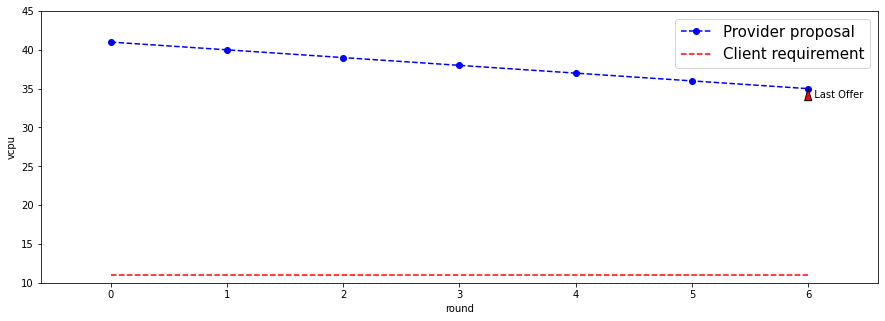

In [28]:
visualize_parameter(steps,vcpu,client_requirement[0],'vcpu')

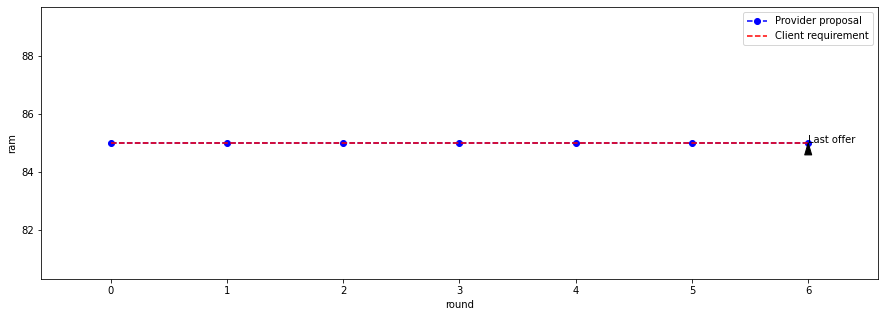

In [12]:
visualize_parameter(steps,ram,client_requirement[1],'ram')

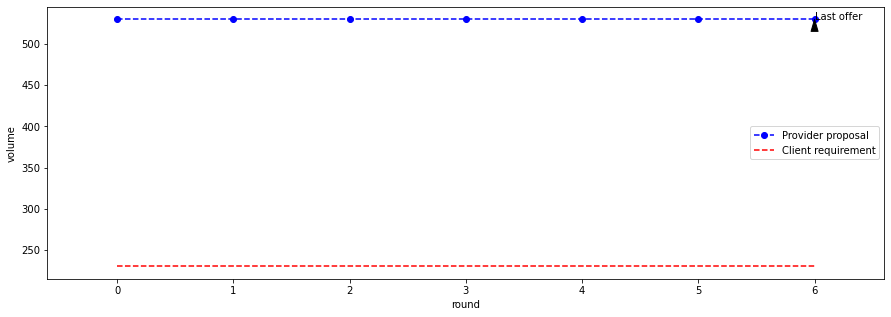

In [13]:
visualize_parameter(steps,volume,client_requirement[2],'volume')

0
10
20
30
40
-1
Saving fig...
Complete!


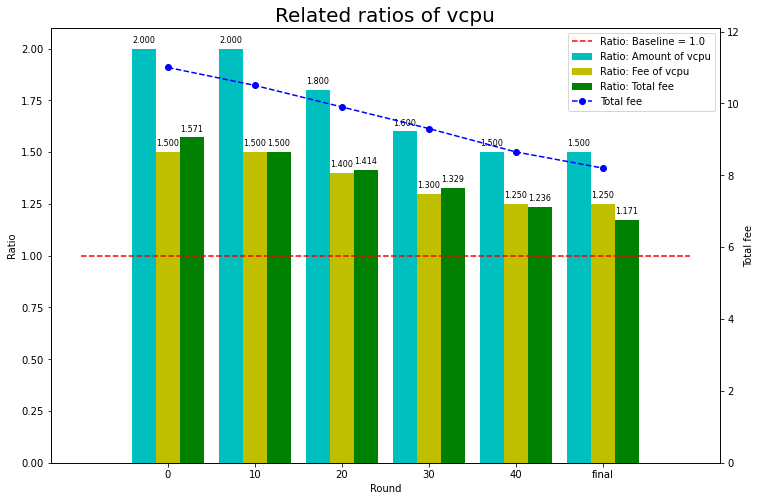

In [46]:
parameter = 'vcpu'
offer_list = [0,10,20,30,40,-1]
offer = vcpu
requirement = client_requirement
total_fee = total_fee
total_fee_old = total_fee_old
avg = avg_vcpu
avg_old = vcpu_avg_old
visualize_gain(parameter,offer_list,offer,requirement,total_fee,total_fee_old,avg,avg_old)

0
10
20
30
40
-1
Saving fig...
Complete!


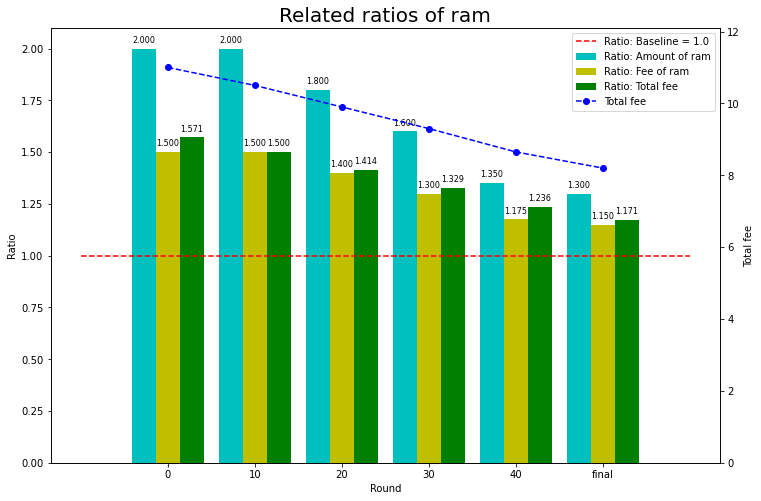

In [47]:
parameter = 'ram'
offer_list = [0,10,20,30,40,-1]
offer = ram
requirement = client_requirement
total_fee = total_fee
total_fee_old = total_fee_old
avg = avg_ram
avg_old = ram_avg_old
visualize_gain(parameter,offer_list,offer,requirement,total_fee,total_fee_old,avg,avg_old)

0
10
20
30
40
-1
Saving fig...
Complete!


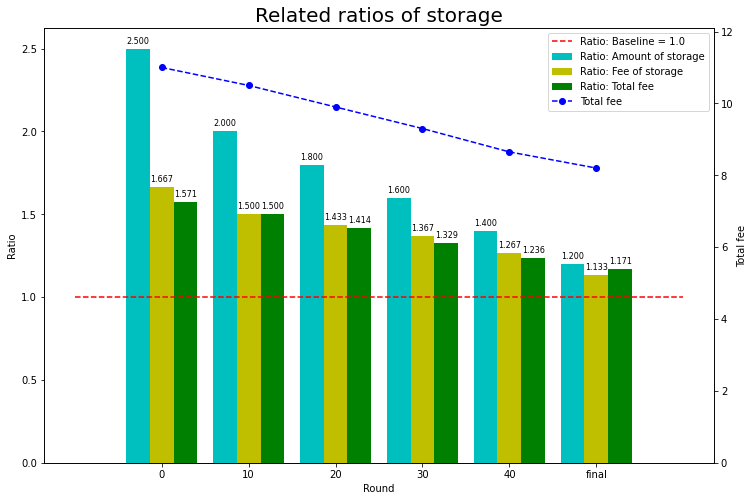

In [49]:
parameter = 'storage'
offer_list = [0,10,20,30,40,-1]
offer = volume
requirement = client_requirement
total_fee = total_fee
total_fee_old = total_fee_old
avg = avg_volume
avg_old = volume_avg_old
visualize_gain(parameter,offer_list,offer,requirement,total_fee,total_fee_old,avg,avg_old)

# Details of fuzzy settings

In [134]:
import sympy as sp
x,mean,std = sp.symbols('x,mean,std')
# from skfuzzy source code
def fuzzy_gaussmf():
    return sp.exp(-((x - mean) ** 2.) / std ** 2.)
g1 = fuzzy_gaussmf()
g2 = fuzzy_gaussmf()
r_high = sp.solve(g2.subs([(x, 80), (mean, 100)])-g1.subs([(x, 80), (mean, 65), (std, (100-65.0)/3)]), std, quick=True)
r_low = sp.solve(g2.subs([(x, 50), (mean, 0)])-g1.subs([(x, 50), (mean, 65), (std, (100-65.0)/3)]), std, quick=True)

In [135]:
print('high std: ',r_high[1])
print('low std: ',r_low[1])

high std:  15.5555555555555
low std:  38.8888888888889


In [9]:
# Fuzzy logic

# New Antecedent/Consequent objects hold universe variables and membership functions
avg_vcpu = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_vcpu')
avg_ram = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_ram')
avg_volume = ctrl.Antecedent(np.arange(0, 101, 1), 'avg_volume')
total_fee = ctrl.Antecedent(np.arange(0, 101, 1), 'total_fee')

tendency = ctrl.Consequent(np.arange(0, 101, 1), 'tendency')

# Auto-membership function population is possible with .automf(3, 5, or 7)
# poor average good, automatically
#names_avg = ['cheap','medium','expensive']
#avg_vcpu.automf(names = names_avg)
#avg_ram.automf(names = names_avg)
#avg_volume.automf(names = names_avg)
#在统计学中，经验法则是在正态分布中，距平均值小于一个标准差、二个标准差、三个标准差以内的百分比，更精确的数字是68.27%、95.45%及99.73%。

avg_vcpu['cheap'] = fuzz.gaussmf(avg_vcpu.universe, 0, 50.0/3)
avg_vcpu['medium'] = fuzz.gaussmf(avg_vcpu.universe, 50, 50.0/3)
avg_vcpu['expensive'] = fuzz.gaussmf(avg_vcpu.universe, 100, 50.0/3)

avg_ram['cheap'] = fuzz.gaussmf(avg_ram.universe, 0, 50.0/3)
avg_ram['medium'] = fuzz.gaussmf(avg_ram.universe, 50, 50.0/3)
avg_ram['expensive'] = fuzz.gaussmf(avg_ram.universe, 100, 50.0/3)

avg_volume['cheap'] = fuzz.gaussmf(avg_volume.universe, 0, 50.0/3)
avg_volume['medium'] = fuzz.gaussmf(avg_volume.universe, 50, 50.0/3)
avg_volume['expensive'] = fuzz.gaussmf(avg_volume.universe, 100, 50.0/3)

#names_total = ['high','medium','low']
#total_fee.automf(names = names_total)
# x=offer/requirement
# x>2 original, weak accepted --> totalfee<0.5
# 2>x>1.5, medium accepted --> 0.5<totalfee<0.8
# 1.5>x, strong accepted --> totalfee>0.8
total_fee['high'] = fuzz.gaussmf(total_fee.universe, 0, 38.8888888888889)
total_fee['medium'] = fuzz.gaussmf(total_fee.universe, 65.0, (100-65.0)/3)
total_fee['low'] = fuzz.gaussmf(total_fee.universe, 100, 15.5555555555555)

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
tendency['low'] = fuzz.gaussmf(tendency.universe, 0, 50.0/3)
tendency['medium'] = fuzz.gaussmf(tendency.universe, 50, 50.0/3)
tendency['high'] = fuzz.gaussmf(tendency.universe, 100, 50.0/3)

F:\ANACONDA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
F:\ANACONDA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
F:\ANACONDA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
F:\ANACONDA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
F:\ANACONDA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://

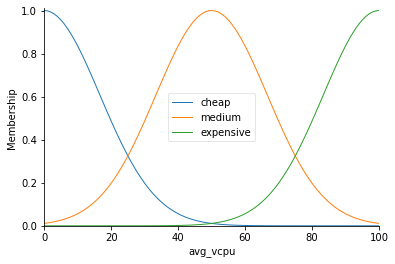

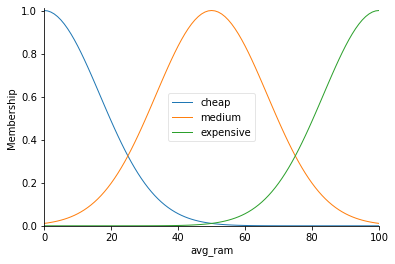

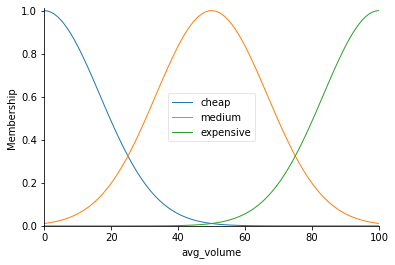

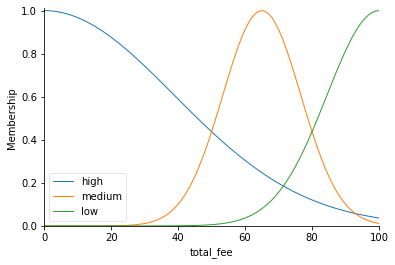

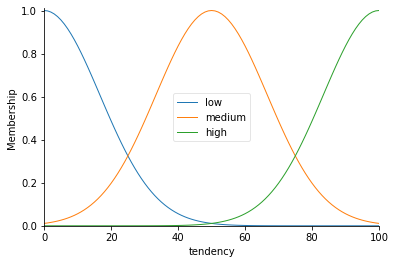

In [10]:
avg_vcpu.view()
avg_ram.view()
avg_volume.view()
total_fee.view()
tendency.view()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1cae59f2160>)

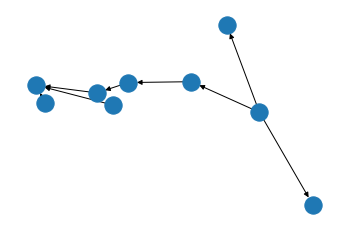

In [11]:
# Rules
# cheap:1,medium:2,expensive:3
# sum: 3, 4, 5, 6, 7, 8, 9
# tendency: 3, 4 high / 5, 6 ,7 medium / 8, 9 low
# could be adjusted
rule01 = ctrl.Rule(total_fee['high'], tendency['low'])
rule02 = ctrl.Rule(total_fee['medium'], tendency['medium'])
rule03 = ctrl.Rule(total_fee['low'], tendency['high'])

rule11 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['cheap'], tendency['high'])#3
rule12 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['medium'], tendency['high'])#4
rule13 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#5
rule14 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['cheap'], tendency['high'])#4
rule15 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#5
rule16 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['medium']&avg_ram['expensive'], tendency['medium'])#6
rule17 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#5
rule18 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['medium'], tendency['medium'])#6
rule19 = ctrl.Rule(avg_vcpu['cheap']&avg_volume['expensive']&avg_ram['expensive'], tendency['medium'])#7

rule21 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['cheap'], tendency['high'])#4
rule22 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['medium'], tendency['medium'])#5
rule23 = ctrl.Rule(avg_vcpu['medium']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#6
rule24 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['cheap'], tendency['medium'])#5
rule25 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#6
rule26 = ctrl.Rule(avg_vcpu['medium']&avg_volume['medium']&avg_ram['expensive'], tendency['medium'])#7
rule27 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#6
rule28 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['medium'], tendency['medium'])#7
rule29 = ctrl.Rule(avg_vcpu['medium']&avg_volume['expensive']&avg_ram['expensive'], tendency['low'])#8

rule31 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['cheap'], tendency['medium'])#5
rule32 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['medium'], tendency['medium'])#6
rule33 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['cheap']&avg_ram['expensive'], tendency['medium'])#7
rule34 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['cheap'], tendency['medium'])#6
rule35 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['medium'], tendency['medium'])#7
rule36 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['medium']&avg_ram['expensive'], tendency['low'])#8
rule37 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['cheap'], tendency['medium'])#7
rule38 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['medium'], tendency['low'])#8
rule39 = ctrl.Rule(avg_vcpu['expensive']&avg_volume['expensive']&avg_ram['expensive'], tendency['low'])#9

rule01.view()

61.51846705362539


F:\ANACONDA\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


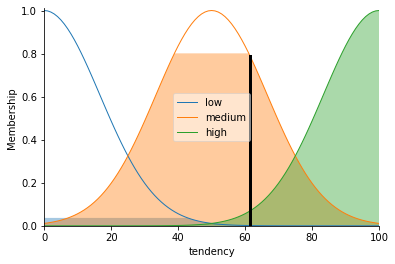

In [12]:
# Fuzzy decision simulation
decision_ctrl = ctrl.ControlSystem([rule01, rule02, rule03, \
                                    rule11, rule12, rule13, rule14, rule15, rule16, rule17, rule18, rule19, \
                                    rule21, rule22, rule23, rule24, rule25, rule26, rule27, rule28, rule29, \
                                    rule31, rule32, rule33, rule34, rule35, rule36, rule37, rule38, rule39, \
                                   ])
decision = ctrl.ControlSystemSimulation(decision_ctrl)
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
# the avg price ratio
# new/old: the cheaper, the better
# ratio: close to 0 is better, close to 1 is worse
# the total fee ratio
# new total fee is always larger than old total fee
# ratio is larger than 1, the larger the worse
# the reciproval is between o and 1. the closer to 0, the worse
# the closer to 1, the better
dict_of_data = {'avg_vcpu': 38.9, 'avg_ram': 38.9, 'avg_volume': 38.9, 'total_fee': 100.0}
#dict_of_data = {'avg_vcpu':input_avg_vcpu,'avg_ram':input_avg_ram,'avg_volume':input_avg_volume,'total_fee':input_total_fee}
decision.inputs(dict_of_data)

# Crunch the numbers
decision.compute()
print(decision.output['tendency'])
tendency.view(sim=decision)

# Compute the scores of ML results

In [67]:
predict_test = pd.read_csv('./data/predict_test_200.csv',index_col=0).reset_index(drop=True)
x_test = pd.read_csv('./data/x_test_200.csv',index_col=0).reset_index(drop=True)
x_pre_test = x_test.join(predict_test)

In [68]:
x_pre_test

,vcpu,ram,volume,0,1,2
0,12,56,730,27.076933,84.052811,730.542236
1,11,41,580,22.533453,65.287308,580.478333
2,1,14,200,5.764062,22.563353,200.364716
3,4,6,530,14.633893,42.128548,530.359009
4,14,41,800,29.439795,81.310028,800.492126
...,...,...,...,...,...,...
195,12,47,900,30.254133,91.318550,900.523987
196,1,12,580,13.634610,48.451141,580.388000
197,46,74,760,54.541744,100.507950,760.565857
198,6,14,380,13.366685,36.027946,380.372864


In [72]:
predict_offer_score_list = []
# Client
client = client_base((0,0,0))
client_decision,tendency = client.fuzzy_decision()
for index,row in tqdm(x_pre_test.iterrows(),total=x_pre_test.shape[0]):
    requirement = (row[0],row[1],row[2])
    offer = (int(row[3]),int(row[4]),int(row[5]))
    #print(offer)
    vcpu_avg_old,ram_avg_old,volume_avg_old,total_fee_old = client.related_fee(requirement)
    vcpu_avg_new,ram_avg_new,volume_avg_new,total_fee_new = client.related_fee(offer)
    # input of fuzzy system
    input_avg_vcpu = 100*client.scale2one_avg('avg', vcpu_avg_old, vcpu_avg_new)
    input_avg_ram = 100*client.scale2one_avg('avg', ram_avg_old, ram_avg_new)
    input_avg_volume = 100*client.scale2one_avg('avg', volume_avg_old, volume_avg_new)
    input_total_fee = 100*client.scale2one_avg('total', total_fee_old, total_fee_new)
    dict_of_data = {'avg_vcpu':input_avg_vcpu,'avg_ram':input_avg_ram,'avg_volume':input_avg_volume,'total_fee':input_total_fee}

    # Client makes decision
    client_decision.inputs(dict_of_data)
    # Crunch the numbers
    client_decision.compute()
    decision_score = client_decision.output['tendency']
    predict_offer_score_list.append(decision_score)

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 443.67it/s]


In [73]:
predict_offer_score_list

[56.05025336562855,
 54.13362402487654,
 41.97937323395505,
 44.94956174419432,
 52.47689663707086,
 49.986804503600005,
 54.98996845633671,
 51.680067955449346,
 56.24210881645374,
 50.89483230649729,
 55.190495711618254,
 52.404053124522456,
 51.9816495486352,
 58.11385699159843,
 54.71249792701401,
 53.42582462201195,
 49.64183374284887,
 52.70079546485676,
 53.5446514952111,
 54.10096309839815,
 53.02255635707219,
 56.907790640290614,
 50.91567217524455,
 50.72702784136778,
 51.28566155667574,
 55.59954111200012,
 52.3154064511056,
 55.22463144101512,
 45.962853096485645,
 48.44493322374302,
 55.34873123478196,
 49.93672659473157,
 53.18376376756664,
 57.18355557515691,
 53.05938105870169,
 53.87846732289511,
 51.47798819486073,
 53.821292342596074,
 45.62565503293935,
 52.18247315703367,
 58.75285300767961,
 49.34494144253886,
 45.79733948756687,
 60.26512131344024,
 53.853704595062744,
 50.40126538114907,
 52.9097101604683,
 47.54306964377607,
 50.94953678282299,
 48.745227393187

In [74]:
accept_score = list(filter(lambda x:x>50,predict_offer_score_list))